In [23]:
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision
import torchvision.utils as utils
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter
from mean_average_precision import MetricBuilder
import progressbar

from wsddn import *

In [2]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_set = CustomVOC('../edge_boxes_model/model.yml.gz', eval_mode=True, root='../../../data', image_set='val', download=False, transform=transform_test)
test_vis_set = CustomVOC('../edge_boxes_model/model.yml.gz', eval_mode=True, root='../../../data', image_set='val', download=False)

In [45]:
model = WSDDN(21)
checkpoint = torch.load('./checkpoints/wsddn_reg_attempt_2/wsdnn_reg_epoch_10.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
model.cuda()

WSDDN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

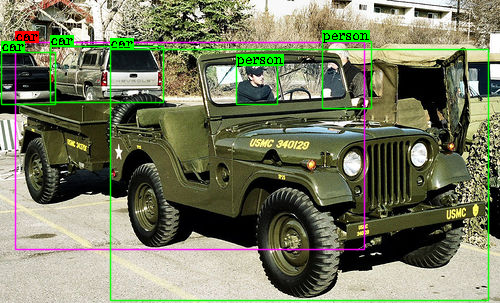

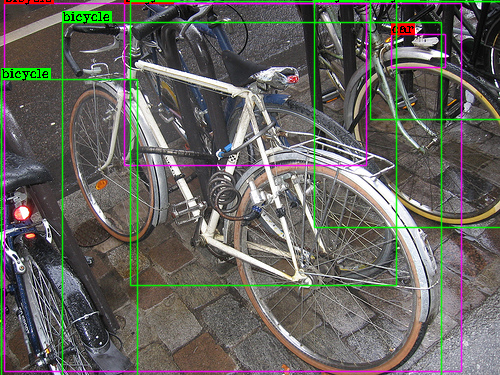

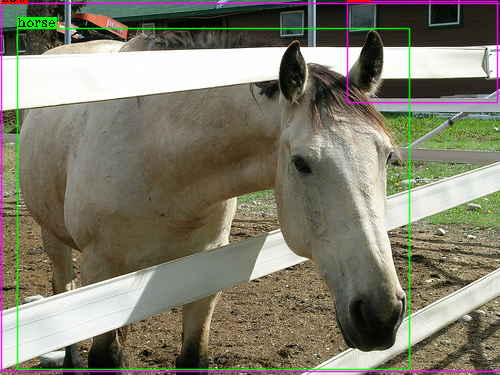

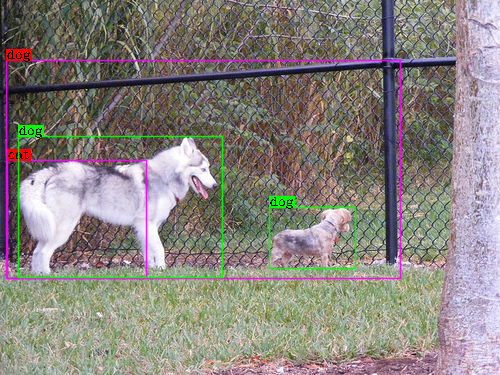

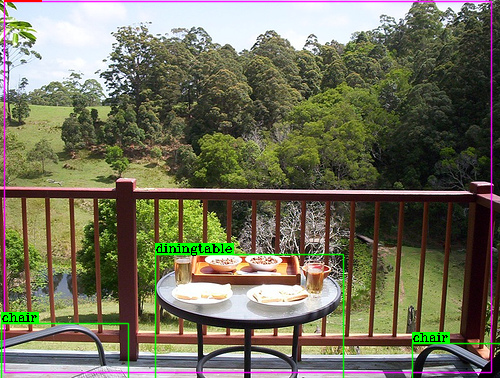

In [47]:
for _ in range(5):
    idx = np.random.randint(len(test_set))
    img, _, _, _ = test_vis_set[idx]
    image, label, boxes, gt_boxes = test_set[idx]
    image = image.reshape([1, image.shape[0], image.shape[1], image.shape[2]])
    image, label, boxes = image.cuda(), label.cuda(), boxes.cuda()
    detections = test_set.format_pred(model.detect(image, boxes))
    display(test_set.draw_boxes(img, detections, gt_boxes, thresh=0.02))

In [16]:
train_set = CustomVOC('../edge_boxes_model/model.yml.gz', eval_mode=True, root='../../../data', image_set='train', download=False, transform=transform_test)
train_vis_set = CustomVOC('../edge_boxes_model/model.yml.gz', eval_mode=True, root='../../../data', image_set='train', download=False)

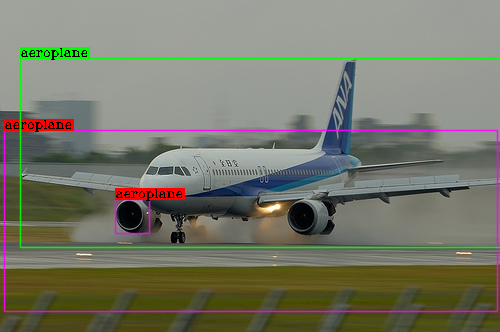

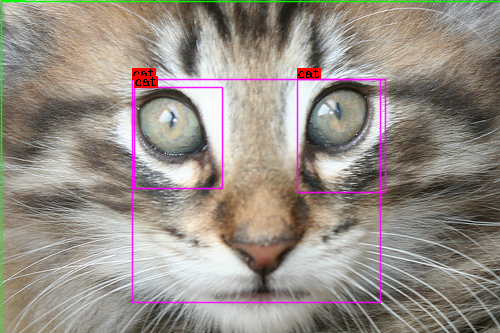

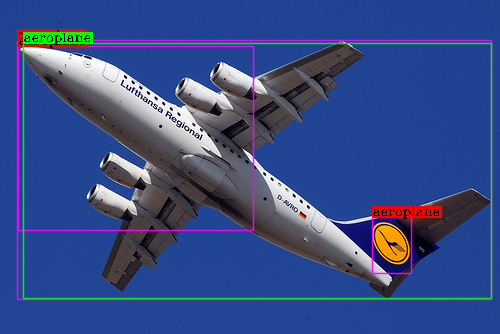

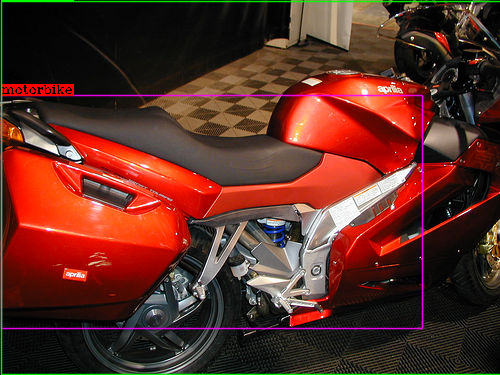

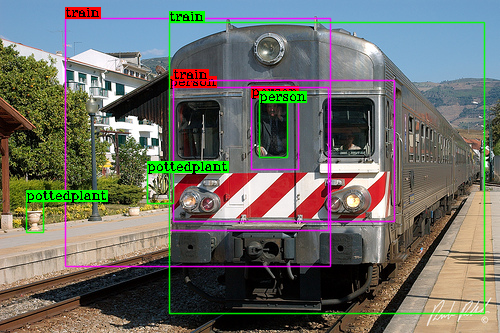

In [54]:
for _ in range(5):
    idx = np.random.randint(len(test_set))
    img, _, _, _ = train_vis_set[idx]
    image, label, boxes, gt_boxes = train_set[idx]
    image = image.reshape([1, image.shape[0], image.shape[1], image.shape[2]])
    image, label, boxes = image.cuda(), label.cuda(), boxes.cuda()
    detections = train_set.format_pred(model.detect(image, boxes))
    display(train_set.draw_boxes(img, detections, gt_boxes, thresh=0.01))

In [21]:
def my_collate(batch):
    data = [item[0] for item in batch]
    label = [item[1] for item in batch]
    boxes = [item[2] for item in batch]
    if (len(batch[0]) == 4):
        gt_boxes = [item[3] for item in batch]
        return data, label, boxes, gt_boxes
    return data, label, boxes

test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0, collate_fn=my_collate)

In [49]:
metric_fn = MetricBuilder.build_evaluation_metric("map_2d", num_classes=21)
with progressbar.ProgressBar(max_value=len(test_set)) as bar:
    for i, stacked_data in enumerate(test_loader):
        for data in zip(stacked_data[0], stacked_data[1], stacked_data[2], stacked_data[3]):
            image_test, _, boxes_test, gt_boxes = data
            image_test = image_test.reshape([1, image_test.shape[0], image_test.shape[1], image_test.shape[2]])

            image_test, boxes_test = image_test.cuda(), boxes_test.cuda()

            detections = model.detect(image_test, boxes_test)
            formatted_detections = test_set.format_pred(detections)
        
            metric_fn.add(np.array(formatted_detections), np.array(gt_boxes))
        
        bar.update(i)
        
mAP = metric_fn.value(iou_thresholds=0.5, recall_thresholds=np.arange(0., 1.1, 0.1))['mAP']

100% (5823 of 5823) |####################| Elapsed Time: 0:03:31 Time:  0:03:31


In [50]:
mAP

0.11637787